## Plant eCO2 Response Parameters

Plant growth is affected by ambient co2 in 2 ways:
1. `co2_uptake_ratio`: CO2 is absorbed more readily, increasing the rate of photosynthesis.
2. `transpiration_efficiency_factor`: Water is used more efficiently, decreasing root uptake and leaf evaporation.

In [3]:
import numpy as np

def calculate_CUR(co2_ppm, t_mean):
    """Calculate the ratio of increased co2 uptake [Vanuytrecht 5]"""
    co2_ppm = min(1000, max(350, co2_ppm))
    tt = (163 - t_mean) / (5 - 0.1 * t_mean) # co2 compensation point
    numerator = (co2_ppm - tt) * (350 + 2 * tt)
    denominator = (co2_ppm + 2 * tt) * (350 - tt)
    return numerator/denominator

def calculate_TEF(co2_ppm):
    """Calculate the ratio of decreased water use [Vanuytrecht 7]"""
    co2_range = [350, 700]
    te_range = [1, 1.37]
    return np.interp(co2_ppm, co2_range, te_range)

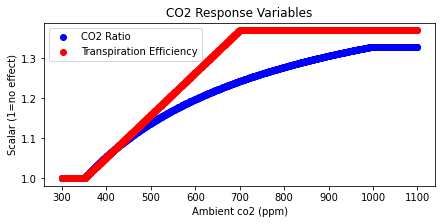

In [4]:
import matplotlib.pyplot as plt

# Test parameters
co2_ppms = [i for i in range(300, 1100)]
t_mean = 25

# Calculate data
datasets = [{'label': 'CO2 Ratio',
             'data': [calculate_CUR(ppm, t_mean) for ppm in co2_ppms],
             'color': 'blue'},
            {'label': 'Transpiration Efficiency',
             'data': [calculate_TEF(ppm) for ppm in co2_ppms],
             'color': 'red'}]
# Plot
plt.figure(figsize=(7,3))
for item in datasets:
    plt.scatter(co2_ppms, item['data'], c=item['color'], label=item['label'])
plt.title("CO2 Response Variables")
plt.ylabel('Scalar (1=no effect)')
plt.xlabel('Ambient co2 (ppm)')
plt.legend()
plt.show()

## 2. Plant eCO2 Currency Exchanges

Plant agents include input and output currency exchanges. The CO2 Response Parameters above affect the following currency exchanges:

#### `co2_uptake_ratio`
- `in_co2`
- `in_fertilizer`
- `in_o2`
- `out_biomass`
- `out_[plant type]`

#### `transpiration_efficiency_factor`
- `in_potable`
- `out_h2o`

In [5]:
import json

# Load SIMOC plant data
with open('data_files/agent_desc.json') as f:
    agent_desc = json.load(f)
with open('data_files/currency_desc.json') as f:
    currency_desc = json.load(f)    
plants = agent_desc['plants']
food = currency_desc['food']

In [6]:
def parse_currency_exchanges(plant):
    """Return a dict of currency exchanges from an agent_desc item"""
    ce = {}
    for (direction, prefix) in zip(['input', 'output'], ['in', 'out']):
        flows = plant['data'][direction]
        for flow in flows:
            key = f"{prefix}_{flow['type']}"
            value = flow['value']
            ce[key] = value
    return ce
    
def adjust_co2_responses(ce, co2_ppm, t_mean=25):
    """Update currency exchange dict based on ambient co2 level and temperature"""
    CUR = calculate_CUR(co2_ppm, t_mean)
    TEF = calculate_TEF(co2_ppm)
    
    cu_fields = ['in_co2', 'in_fertilizer', 'out_o2', 'out_biomass']
    te_fields = ['in_potable', 'out_h2o']
    
    output = {}
    for field, value in ce.items():
        if field in cu_fields:
            output[field] = value * CUR
        elif field in te_fields:
            output[field] = value * (1 / TEF)
        else:
            output[field] = value
    return output

In [7]:
co2_ppms = [350, 700]
test_plant = 'wheat'

ce = parse_currency_exchanges(plants[test_plant])
datasets = [adjust_co2_responses(ce, ppm) for ppm in co2_ppms]

for ppm, values in zip(co2_ppms, datasets):
    print(ppm)
    for k, v in values.items():
        print(k, v)

350
in_co2 0.002547123016
in_potable 0.01125
in_fertilizer 3.882e-05
in_kwh 0.8018183846
in_biomass 1
out_o2 0.0018526785714
out_h2o 0.0098999291113
out_wheat 0.4
out_inedible_biomass 0.6
out_biomass 0.002083333
700
in_co2 0.003165070239774781
in_potable 0.008211678832116789
in_fertilizer 4.8237963355617134e-05
in_kwh 0.8018183846
in_biomass 1
out_o2 0.002302149434233135
out_h2o 0.007226225628686132
out_wheat 0.4
out_inedible_biomass 0.6
out_biomass 0.0025887620018430683


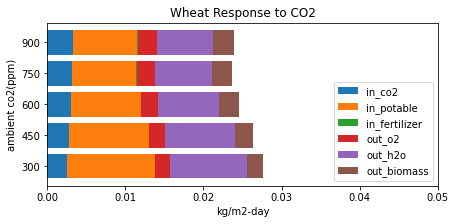

In [8]:
from matplotlib import pyplot as plt

# Test parameters
co2_ppms = [i for i in range(300, 901, 150)]
test_plant = 'wheat'

# Calculate data
ce = parse_currency_exchanges(plants[test_plant])
datasets = [adjust_co2_responses(ce, ppm) for ppm in co2_ppms]

# Compile fields for chart
dataset_labels = [str(p) for p in co2_ppms]
fields = list(datasets[0].keys())
irrelevant = ['in_kwh', 'in_biomass', f'out_{test_plant}', 'out_inedible_biomass']

# cpmd_sorted = dict(sorted(cpmd_dict.items(), key=lambda i: i[1]))
# fig, ax = plt.subplots()
# y_pos = np.arange(len(cpmd_sorted.keys()))
# ax.barh(y_pos, cpmd_sorted.values(), tick_label=list(cpmd_sorted.keys()))
# ax.set_xlabel('kcal/m2-day')
# ax.set_title('Plant Utility: Calories per m2 per day')
# plt.plot()

# Plot
fig, ax = plt.subplots(figsize=(7,3))
cumulative = [0] * len(dataset_labels)
for field in fields:
    if field in irrelevant:
        continue
    values = [ds[field] for ds in datasets]
    ax.barh(dataset_labels, values, left=cumulative, label=field)
    cumulative = [a + b for a, b in zip(cumulative, values)]
ax.legend(loc='lower right')
plt.title(f"Wheat Response to CO2")
plt.ylabel('ambient co2(ppm)')
plt.xlabel('kg/m2-day')
ax.set_xlim([0, .05])
plt.show()

## 3. Plant Utility Metrics

In the context of a Mars habitat, plants produce edible food and also perform bioregeneration. 

The relative utility of plant species is measured by:
1. `calories_per_m2_day`: The total amount of edible calories produced by one square meter of plants divided by its lifetime
2. `kwh_offset_per_day`: The average daily reduction in energy (kwh) required for bioregeneration over the life of the plant.

### 3a. Calories per m2 day

In [9]:
def parse_plant_nutrition(plant, biomass):
    """Return edible kcal in a quantity of plant biomass"""
    for ce in plants[plant]['data']['output']:
        if ce['type'] == plant:
            edible_ratio = ce['value']
    kcal_per_kg = food[plant]['nutrition']['kcal']
    return biomass * edible_ratio * kcal_per_kg

[]

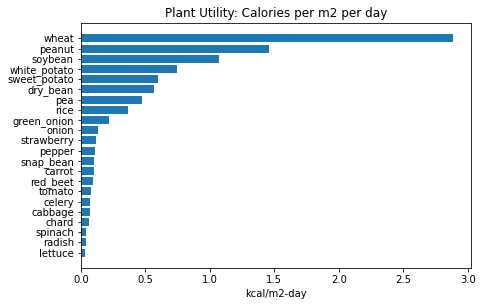

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# Calculate cpmd for all plants
cpmd_dict = {}
for plant, plant_data in plants.items():
    for flow in plant_data['data']['output']:
        if flow['type'] == 'biomass':
            average_daily_biomass_production = flow['value']
            break
    calories_per_m2_day = parse_plant_nutrition(plant, average_daily_biomass_production)
    cpmd_dict[plant] = calories_per_m2_day
    
# plot
cpmd_sorted = dict(sorted(cpmd_dict.items(), key=lambda i: i[1]))
fig, ax = plt.subplots(figsize=(7,4.5))
y_pos = np.arange(len(cpmd_sorted.keys()))
ax.barh(y_pos, cpmd_sorted.values(), tick_label=list(cpmd_sorted.keys()))
ax.set_xlabel('kcal/m2-day')
ax.set_title('Plant Utility: Calories per m2 per day')
plt.plot()

### 3b. kWh Offset Calculation

Plants' interaction with life support systems comprises 4 currencies:

#### `co2`
- Baseline: consume co2 (benefit)
- eCO2: consume *more* co2 (benefit)
- ECLSS: `co2_reduction_sabatier` (co2 + h2 + kwh -> ch4 + water) and `co2_reduction_SAWD` (co2 + kwh -> storage)
- Price: kwh required to remove 1kg from atmosphere, average of sabatier and SAWD

#### `o2`
- Baseline: produce o2 (benefit)
- eCO2: produce *more* co2 (benefit)
- ECLSS: `oxygen_generation_SFWE` (potable + kwh -> h2 + o2)
- Price: kwh required to produce 1kg of o2
  
#### `potable`(water):
- Baseline: consumes potable (cost)
- eCO2: consume *less* potable (benefit)
- ECLSS: `multifiltration_purifier_post_treatment` (treated + kwh -> potable), `dehumidifier` (h2o + kwh -> potable)
- Price: kwh required to produce 1kg of potable, average of multifiltration and dehumidifier
  
#### `h2o`(water vapor):
- Baseline: produces h2o (cost)
- eCO2: produces *less* co2 (benefit)
- ECLSS: `dehumidifier` (h2o + kwh -> potable)
- Price: kwh required to remove 1kg of h2o from atmosphere

In [9]:
from collections import Counter
from functools import reduce

# Get ECLSS agent currency exchanges
eclss = agent_desc['eclss']
def ce_values(agent, currencies):
    """Return a counter of currency exchange values for given agent and currencies"""
    output = {}
    for direction in ['input', 'output']:
        for flow in eclss[agent]['data'][direction]:
            if flow['type'] in currencies:
                output[flow['type']] = flow['value']
    return Counter(output)

# Calculate kwh price for relevant fields
kwh_cost_fields = {'in_co2': (1, ['co2_reduction_sabatier', 'co2_removal_SAWD']),
                   'out_o2': (1, ['oxygen_generation_SFWE']),
                   'in_potable': (-1, ['dehumidifier', 'multifiltration_purifier_post_treatment']),
                   'out_h2o': (-1, ['dehumidifier'])}
kwh_prices = {}
for field, (mul, agents) in kwh_cost_fields.items():
    currency = field.split('_')[1]
    ce_counters = [ce_values(a, [currency, 'kwh']) for a in agents]
    ce = reduce(lambda a, b: a + b, ce_counters)
    kwh_prices[field] = mul * ce['kwh']/ce[currency]

def calculate_kwh_offset(ce):
    """Return the net kwh cost/benefit from a currency exchange dict"""
    net = 0
    for field, value in kwh_prices.items():
        if field in ce:
            net += value * ce[field]
    return net

for k, v in kwh_prices.items():
    print(k, v)

in_co2 10.28033299101973
out_o2 2.6130790190735693
in_potable -0.10778947368421053
out_h2o -0.125


[]

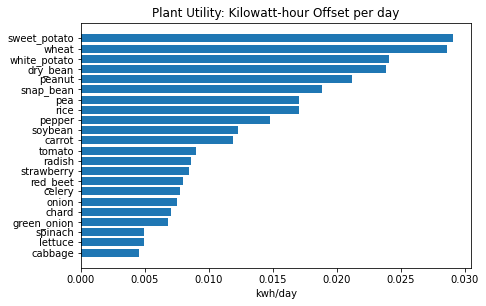

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# Calculate kopd for all plants
kopd_dict = {}
for plant, plant_data in plants.items():
    test_plant = 'rice'
    ce = parse_currency_exchanges(plant_data)
    kopd_dict[plant] = calculate_kwh_offset(ce)
    
# plot
kopd_dict = dict(sorted(kopd_dict.items(), key=lambda i: i[1]))
fig, ax = plt.subplots(figsize=[7, 4.5])
y_pos = np.arange(len(kopd_dict.keys()))
ax.barh(y_pos, kopd_dict.values(), tick_label=list(kopd_dict.keys()))
ax.set_xlabel('kwh/day')
ax.set_title('Plant Utility: Kilowatt-hour Offset per day')
plt.plot()

## 3c. Combined Utility

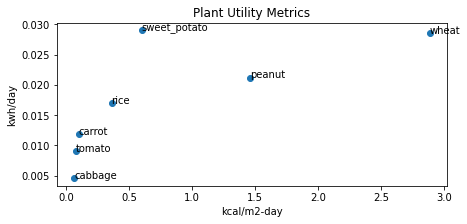

In [11]:
import matplotlib.pyplot as plt

x = []
y = []
show_plants = ['wheat', 'sweet_potato', 'peanut', 'rice', 'carrot', 'tomato', 'cabbage']
for plant in show_plants:
    x.append(cpmd_dict[plant])
    y.append(kopd_dict[plant])

plt.figure(figsize=(7, 3))
plt.scatter(x, y)
plt.title('Plant Utility Metrics')
plt.ylabel('kwh/day')
plt.xlabel('kcal/m2-day')

for i, plant in enumerate(show_plants):
    plt.annotate(plant, (x[i], y[i]))

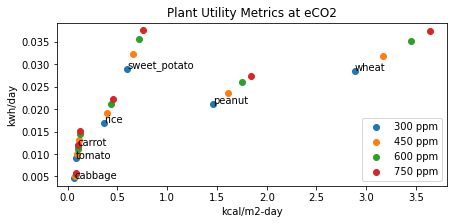

In [18]:
co2_ppms = [i for i in range(300, 900, 150)]

plt.figure(figsize=(7, 3))
show_plants = ['wheat', 'sweet_potato', 'peanut', 'rice', 'carrot', 'tomato', 'cabbage']
plant_ce = {k: parse_currency_exchanges(v) for k, v in plants.items()}
plant_ce = {k: v for k, v in plant_ce.items() if k in show_plants}
for ppm in co2_ppms:
    plant_ce_adj = {k: adjust_co2_responses(v, ppm) for k, v in plant_ce.items()}
    cpmd = [parse_plant_nutrition(k, v['out_biomass']) for k, v in plant_ce_adj.items()]
    kopd = [calculate_kwh_offset(v) for k, v in plant_ce_adj.items()]
    plt.scatter(cpmd, kopd, label=f"{ppm} ppm")
for i, plant in enumerate(show_plants):
    plt.annotate(plant, (x[i], y[i]))
plt.legend(loc='lower right')
plt.title('Plant Utility Metrics at eCO2')
plt.ylabel('kwh/day')
plt.xlabel('kcal/m2-day')
plt.show()

# Garden Scenario

In [68]:
def parse_garden_nutrition(garden):
    
    # Load SIMOC plant data
    with open('data_files/agent_desc.json') as f:
        agent_desc = json.load(f)
    with open('data_files/currency_desc.json') as f:
        currency_desc = json.load(f)    
    plants = agent_desc['plants']
    food = currency_desc['food']

    def parse_plant_nutrition(plant, biomass):
        """Return edible kcal in a quantity of plant biomass"""
        for ce in plants[plant]['data']['output']:
            if ce['type'] == plant:
                edible_ratio = ce['value']
        daily_kg = biomass * edible_ratio
        nutrition = {k: v * daily_kg for k, v in food[plant]['nutrition'].items()}
        return nutrition

    plant_nutrition = {}
    for (plant, amount) in garden:
        plant_data = plants[plant]
        for flow in plant_data['data']['output']:
            if flow['type'] == 'biomass':
                average_daily_biomass_production = flow['value']
                break
        biomass = average_daily_biomass_production * amount
        plant_nutrition[plant] = parse_plant_nutrition(plant, biomass)

    total_nutrition = None
    for nutrition in plant_nutrition.values():
        if not total_nutrition:
            total_nutrition = nutrition
        else:
            for k, v in nutrition.items():
                total_nutrition[k] += v
    return total_nutrition
    
garden = [('wheat', 80),
          ('peanut', 100),
          ('tomato', 50),
          ('chard', 50)]
hourly_nutrition = parse_garden_nutrition(garden)
daily_nutrition = {k: v*24 for k, v in hourly_nutrition.items()}

macronutrients = ['protein', 'carbohydrate', 'fat']
macro_total = sum([v for k, v in daily_nutrition.items() if k in macronutrients])
macro_ratio = {k: daily_nutrition[k]/macro_total for k in macronutrients}
print(daily_nutrition)
print(macro_ratio)

{'kcal': 9223.055987520722, 'water': 1054.199154202392, 'protein': 340.29419486904, 'carbohydrate': 1207.2288954688079, 'fat': 328.3014843482401}
{'protein': 0.1814104578121261, 'carbohydrate': 0.6435723850514289, 'fat': 0.17501715713644495}


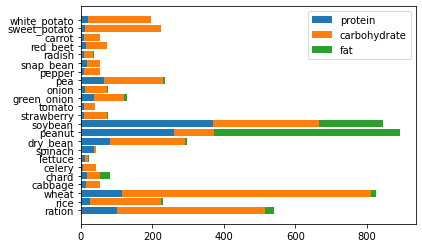

In [32]:
import matplotlib.pyplot as plt

macros = dict(protein=[], carbohydrate=[], fat=[])
labels = []
for plant, data in currency_desc['food'].items():
    if 'nutrition' not in data:
        continue
    labels.append(plant)
    for k, v in macros.items():
        v.append(data['nutrition'][k])

fig, ax = plt.subplots()
cumulative = [0] * len(labels)
for field, values in macros.items():
    ax.barh(labels, values, left=cumulative, label=field)
    cumulative = [a + b for a, b in zip(cumulative, values)]
plt.legend()
plt.show()
